# Задача 2. Сравнение методов классификации
#### Пелогейко Макар Андреевич, 471
* **Дедлайн**: 20.11.2022, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 9

## Задача

- [x] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- [x] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блокнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
- [x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- [x] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
- [x] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- [x] * (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
- [x] * (**+2 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

In [158]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import norm
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.datasets import load_wine

#### EDA

In [159]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [161]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

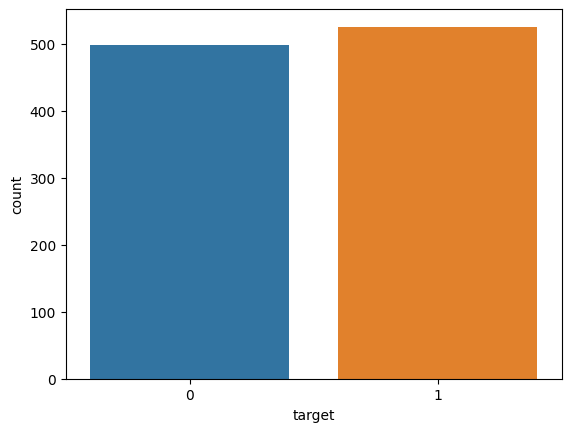

In [162]:
sns.countplot(x="target", data=df)
plt.show()

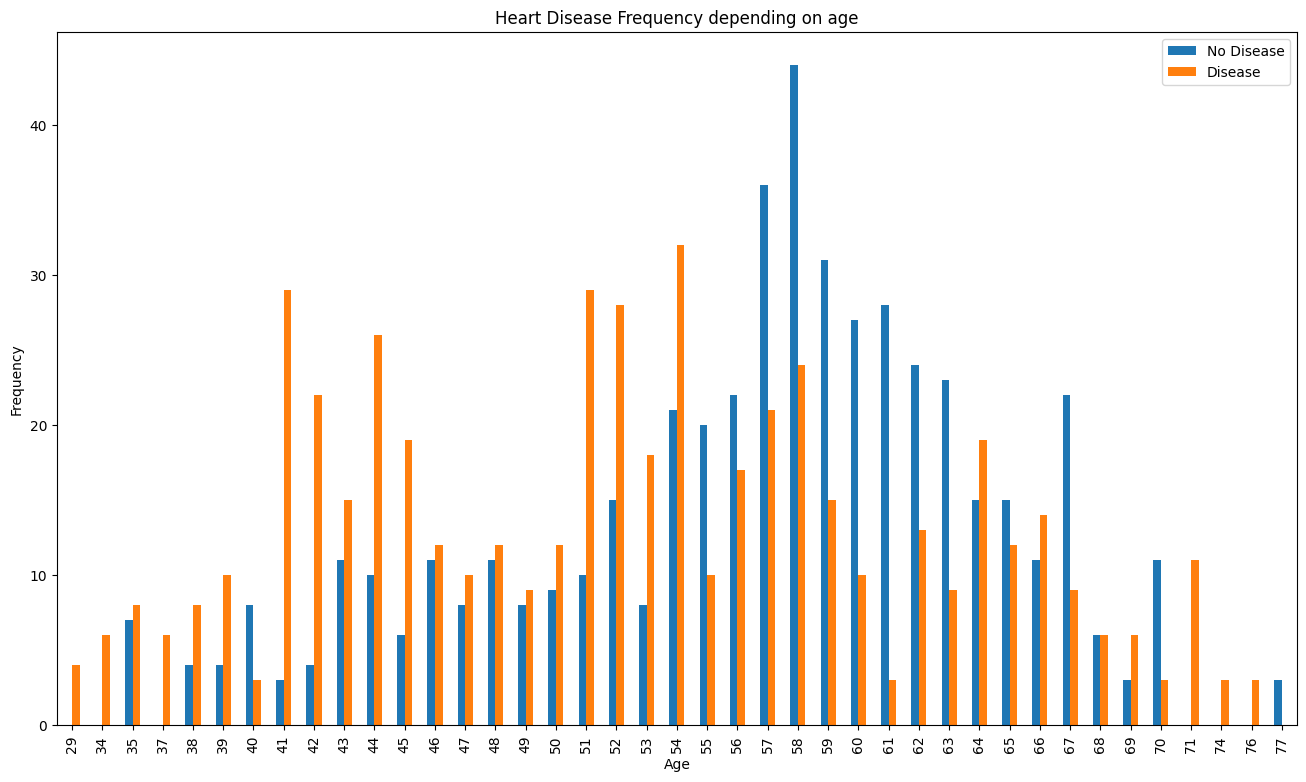

In [163]:
# Зависимость заболеваний в зависимости от возраста
pd.crosstab(df.age,df.target).plot(kind="bar",figsize=(16,9))
plt.title('Heart Disease Frequency depending on age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(["No Disease", "Disease"])
plt.show()

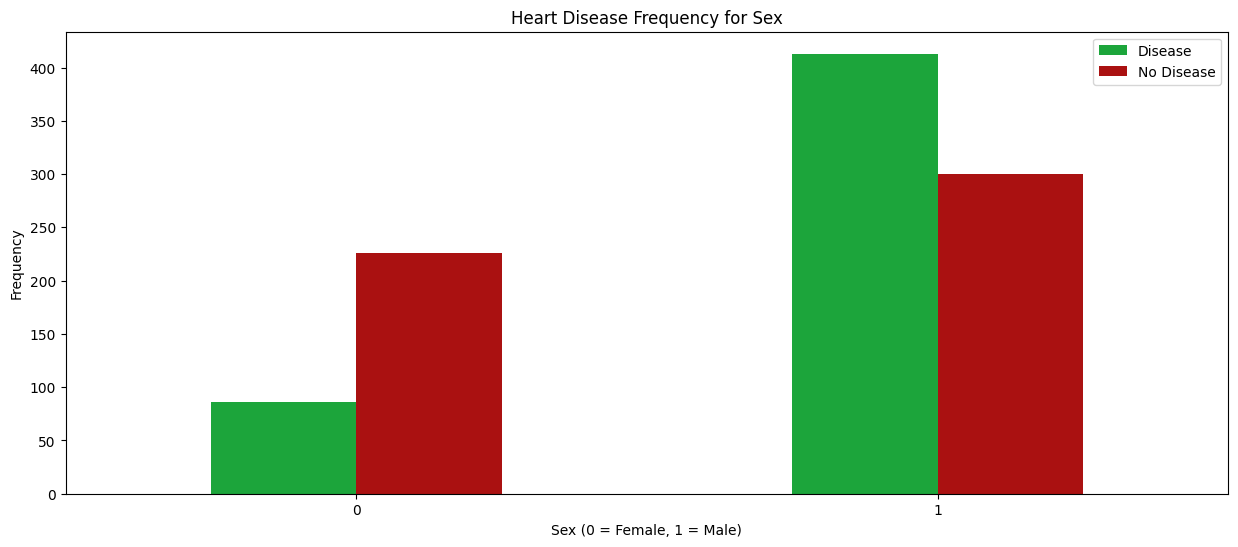

In [164]:
# Зависимость заболеваний в зависимости от пола
pd.crosstab(df.sex,df.target).plot(kind="bar",figsize=(15,6),color=['#1CA53B','#AA1111' ])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Disease", "No Disease"])
plt.ylabel('Frequency')
plt.show()

#### Feature Engineering

In [165]:
cp_dum = pd.get_dummies(df['cp'], prefix = "cp")
thal_dum = pd.get_dummies(df['thal'], prefix = "thal")
slope_dum = pd.get_dummies(df['slope'], prefix = "slope")

frames = [df, cp_dum, thal_dum, slope_dum]
df = pd.concat(frames, axis = 1)
df = df.drop(columns = ['cp', 'thal', 'slope'])
df.columns

Index(['age', 'sex', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang',
       'oldpeak', 'ca', 'target', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'thal_0',
       'thal_1', 'thal_2', 'thal_3', 'slope_0', 'slope_1', 'slope_2'],
      dtype='object')

#### Случайным образом разбить данные на обучающую и тестовую выборки, используя методы существующих библиотек.

In [166]:
x = df.drop(['target'], axis=1)
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [167]:
# Масштабирование данных
scaler = StandardScaler()

x_train_scaled_raw = scaler.fit_transform(x_train)
x_test_scaled_raw = scaler.transform(x_test)

x_train_scaled = pd.DataFrame(x_train_scaled_raw, columns=x.columns)
x_test_scaled = pd.DataFrame(x_test_scaled_raw, columns=x.columns)
x_train_scaled.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,0.278866,0.666080,-0.191919,-0.315746,-0.418073,-1.052191,0.048465,-0.685226,-0.568679,0.231370,...,-0.453743,1.621209,-0.27589,-0.078326,-0.246581,-1.062953,1.209323,-0.273322,1.065559,-0.927044
1,1.489925,-1.501322,-0.658038,-0.656319,-0.418073,-1.052191,-1.453630,-0.685226,0.398601,-0.736607,...,-0.453743,1.621209,-0.27589,-0.078326,-0.246581,0.940775,-0.826909,-0.273322,1.065559,-0.927044
2,-0.051423,0.666080,-1.240687,-0.126538,-0.418073,0.827540,-0.981543,1.459373,1.541750,0.231370,...,-0.453743,-0.616824,-0.27589,-0.078326,-0.246581,-1.062953,1.209323,-0.273322,1.065559,-0.927044
3,-1.152386,-1.501322,-0.774568,-0.069776,-0.418073,0.827540,0.005548,-0.685226,-0.656614,0.231370,...,-0.453743,1.621209,-0.27589,-0.078326,-0.246581,0.940775,-0.826909,-0.273322,1.065559,-0.927044
4,-2.143252,-1.501322,0.390730,-1.186100,-0.418073,0.827540,1.421808,-0.685226,0.310666,-0.736607,...,-0.453743,-0.616824,-0.27589,-0.078326,-0.246581,0.940775,-0.826909,-0.273322,-0.938474,1.078698


#### Реализация метода опорных векторов

In [168]:
class SVMMyView(ClassifierMixin):
    def __init__(self, learning_rate=0.001, iter_num=10000, lambda_=0.01):
        self.learning_rate = learning_rate
        self.iter_num = iter_num
        self.lambda_ = lambda_


    def fit(self, x_matrix, y):
        x_matrix, y = check_X_y(x_matrix, y)

        self.x_matrix_ = x_matrix
        self.y = y
        n = x_matrix.shape[1]
        self.w = np.zeros(n)
            
        for i in range(self.iter_num):
            self.b = 0
            y_target = np.where(y <= 0, -1, 1)
            for index, x_i in enumerate(x_matrix):
                
                if y_target[index] * (np.dot(x_i, self.w) - self.b) >= 1:
                    dw = 2 * self.lambda_ * self.w
                    db = 0
                else:
                    dw = 2 * self.lambda_ * self.w - np.dot(x_i, y_target[index])
                    db = y_target[index]
                self.w = self.w - self.learning_rate * dw
                self.b = self.b - self.learning_rate * db
                #########
        return self

    def predict(self, x_matrix):
        check_is_fitted(self)
        x_matrix = check_array(x_matrix)
        output = np.dot(x_matrix, self.w) - self.b
        predicted_labels = np.sign(output)
        y_hat = np.where(predicted_labels <= -1, 0, 1)
        return y_hat

    def get_params(self, deep=True):
        return {"learning_rate": self.learning_rate, "iter_num": self.iter_num, "lambda_": self.lambda_}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

#### Реализация KNN

In [169]:
class KNNMyView(ClassifierMixin):
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors

    def fit(self, x_matrix, y):
        x_matrix, y = check_X_y(x_matrix, y)

        # self.x_matrix = x_matrix.to_numpy()
        self.x_matrix = x_matrix
        self.y = y
        return self

    def predict(self, x_matrix):
        np_input = x_matrix.to_numpy()
        # np_input = x_matrix
        result = []
        for line in np_input:
            distances = np.linalg.norm(self.x_matrix - line, axis=1)
            nearest_neighbor_ids = distances.argsort()[:self.n_neighbors]
            nearest_neighbor_rings = self.y[nearest_neighbor_ids]
            counts = np.bincount(nearest_neighbor_rings.astype(int))
            y = np.argmax(counts)
            result.append(y)

        return np.array(result)

    def get_params(self, deep=True):
        return {"n_neighbors": self.n_neighbors}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

#### Перед обучением моделей подобрать наилучшее количество (и само подмножество) признаков.

In [170]:
rfecv = RFECV(estimator=LogisticRegression())

rfecv.fit(x_train_scaled, y_train)

selected_features = list(x_train_scaled.columns[rfecv.support_])

print(f'Оптимальных признаков: {rfecv.n_features_}\nПризнкаи:{selected_features}')

Оптимальных признаков: 11
Признкаи:['sex', 'chol', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_0', 'cp_2', 'thal_1', 'thal_2', 'slope_2']


In [171]:
x_train_scaled = x_train_scaled[selected_features]
x_test_scaled = x_test_scaled[selected_features]
x_train_scaled.head()

,sex,chol,thalach,exang,oldpeak,ca,cp_0,cp_2,thal_1,thal_2,slope_2
0,0.666080,-0.315746,0.048465,-0.685226,-0.568679,0.231370,-0.966417,1.621209,-0.246581,-1.062953,-0.927044
1,-1.501322,-0.656319,-1.453630,-0.685226,0.398601,-0.736607,-0.966417,1.621209,-0.246581,0.940775,-0.927044
2,0.666080,-0.126538,-0.981543,1.459373,1.541750,0.231370,1.034750,-0.616824,-0.246581,-1.062953,-0.927044
3,-1.501322,-0.069776,0.005548,-0.685226,-0.656614,0.231370,-0.966417,1.621209,-0.246581,0.940775,-0.927044
4,-1.501322,-1.186100,1.421808,-0.685226,0.310666,-0.736607,1.034750,-0.616824,-0.246581,0.940775,1.078698


In [172]:
learning_rate_grid = [0.1, 0.001]
iter_num_grid = [100, 1000]
lmda_grid = [0.1, 0.001]

cv = StratifiedKFold(5)
searcher = GridSearchCV(SVMMyView(),
                        [{"learning_rate": learning_rate_grid, "iter_num": iter_num_grid, "lambda_": lmda_grid}],
                        cv=cv, verbose=5)
searcher.fit(x_train_scaled, y_train)

optimal_learning_rate = searcher.best_params_["learning_rate"]
optimal_iter_num = searcher.best_params_["iter_num"]
optimal_lambda = searcher.best_params_["lambda_"]
############
print(f"Optimal options {searcher.best_params_}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END iter_num=100, lambda_=0.1, learning_rate=0.1;, score=0.756 total time=   0.1s
[CV 2/5] END iter_num=100, lambda_=0.1, learning_rate=0.1;, score=0.780 total time=   0.1s
[CV 3/5] END iter_num=100, lambda_=0.1, learning_rate=0.1;, score=0.823 total time=   0.1s
[CV 4/5] END iter_num=100, lambda_=0.1, learning_rate=0.1;, score=0.799 total time=   0.1s
[CV 5/5] END iter_num=100, lambda_=0.1, learning_rate=0.1;, score=0.744 total time=   0.1s
[CV 1/5] END iter_num=100, lambda_=0.1, learning_rate=0.001;, score=0.848 total time=   0.1s
[CV 2/5] END iter_num=100, lambda_=0.1, learning_rate=0.001;, score=0.793 total time=   0.1s
[CV 3/5] END iter_num=100, lambda_=0.1, learning_rate=0.001;, score=0.884 total time=   0.1s
[CV 4/5] END iter_num=100, lambda_=0.1, learning_rate=0.001;, score=0.829 total time=   0.1s
[CV 5/5] END iter_num=100, lambda_=0.1, learning_rate=0.001;, score=0.811 total time=   0.1s
[CV 1/5] END iter_nu

In [173]:
n_neighbors = [3, 5, 7]

cv = StratifiedKFold(5)
knn_clf = GridSearchCV(KNNMyView(), 
                       [{"n_neighbors": n_neighbors}],
                       cv=cv, verbose=5)

knn_clf.fit(x_train_scaled, y_train)

optimal_neighbors = knn_clf.best_params_["n_neighbors"]
############
print(f"Optimal options {knn_clf.best_params_}, best: {knn_clf.best_score_}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .....................n_neighbors=3;, score=0.933 total time=   0.0s
[CV 2/5] END .....................n_neighbors=3;, score=0.866 total time=   0.0s
[CV 3/5] END .....................n_neighbors=3;, score=0.902 total time=   0.0s
[CV 4/5] END .....................n_neighbors=3;, score=0.921 total time=   0.0s
[CV 5/5] END .....................n_neighbors=3;, score=0.927 total time=   0.0s
[CV 1/5] END .....................n_neighbors=5;, score=0.878 total time=   0.0s
[CV 2/5] END .....................n_neighbors=5;, score=0.829 total time=   0.0s
[CV 3/5] END .....................n_neighbors=5;, score=0.860 total time=   0.0s
[CV 4/5] END .....................n_neighbors=5;, score=0.884 total time=   0.0s
[CV 5/5] END .....................n_neighbors=5;, score=0.848 total time=   0.0s
[CV 1/5] END .....................n_neighbors=7;, score=0.884 total time=   0.0s
[CV 2/5] END .....................n_neighbors=7;,

#### Тестирование

In [174]:
accuracies = dict()
recalls = dict()

In [175]:
classifier = SVMMyView(learning_rate=optimal_learning_rate, iter_num=optimal_iter_num, lambda_=optimal_lambda)
classifier.fit(x_train_scaled, y_train)



y_test_prediction_svm_my = classifier.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_test_prediction_svm_my)
recall = recall_score(y_test, y_test_prediction_svm_my)

accuracies['SVMMyView'] = accuracy
recalls['SVMMyView'] = recall

print(f"Test Accuracy of SVM my View alghoritm: {accuracy}, recall: {recall}")

Test Accuracy of SVM my View alghoritm: 0.8634146341463415, recall: 0.8761904761904762


In [176]:
classifier = KNNMyView(optimal_neighbors)
classifier.fit(x_train_scaled, y_train)



y_test_prediction_knn_my = classifier.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_test_prediction_knn_my)
recall = recall_score(y_test, y_test_prediction_knn_my)

accuracies['KNNMyView'] = accuracy
recalls['KNNMyView'] = recall

print(f"Test Accuracy of KNN my View alghoritm: {accuracy}, recall: {recall}")

Test Accuracy of KNN my View alghoritm: 0.9804878048780488, recall: 0.9809523809523809


### Повторить предыдущий пункт для библиотечных реализаций (например, из sklearn) всех пройденных методов классификации (logistic regression, svm, knn, naive bayes, decision tree).

In [177]:
log_reg = LogisticRegression(C=0.5)
log_reg.fit(x_train_scaled, y_train)

y_test_prediction_log = log_reg.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_test_prediction_log)
recall = recall_score(y_test, y_test_prediction_log)

accuracies['log_reg'] = accuracy
recalls['log_reg'] = recall

print(f"Test Accuracy of logistic regression alghoritm: {accuracy}, recall: {recall}")

Test Accuracy of logistic regression alghoritm: 0.848780487804878, recall: 0.8857142857142857


In [178]:
svm = SVC(C=0.5, gamma=1, kernel='rbf', random_state = 42)
svm.fit(x_train_scaled, y_train)

y_test_prediction_svm = svm.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_test_prediction_svm)
recall = recall_score(y_test, y_test_prediction_svm)

accuracies['SVM'] = accuracy
recalls['SVM'] = recall

print(f"Test Accuracy of SVM alghoritm: {accuracy}, recall: {recall}")

Test Accuracy of SVM alghoritm: 0.9414634146341463, recall: 0.8857142857142857


In [179]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(x_train_scaled, y_train)

y_test_prediction_knn = knn.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_test_prediction_knn)
recall = recall_score(y_test, y_test_prediction_knn)

accuracies['KNN'] = accuracy
recalls['KNN'] = recall

print(f"Test Accuracy of KNN alghoritm: {accuracy}, recall: {recall}")

Test Accuracy of KNN alghoritm: 1.0, recall: 1.0


In [180]:
nb = GaussianNB(priors=[0.6, 0.4], var_smoothing=0.5)
nb.fit(x_train_scaled, y_train)

y_test_prediction_nb = nb.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_test_prediction_nb)
recall = recall_score(y_test, y_test_prediction_nb)

accuracies['NB'] = accuracy
recalls['NB'] = recall

print(f"Test Accuracy of naive bayes alghoritm: {accuracy}, recall: {recall}")

Test Accuracy of naive bayes alghoritm: 0.848780487804878, recall: 0.8380952380952381


In [181]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=5, max_features=2)
dtc.fit(x_train_scaled, y_train)

y_test_prediction_dtc = dtc.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_test_prediction_dtc)
recall = recall_score(y_test, y_test_prediction_dtc)

accuracies['DTC'] = accuracy
recalls['DTC'] = recall

print(f"Test Accuracy of SVM my View alghoritm: {accuracy}, recall: {recall}")

Test Accuracy of SVM my View alghoritm: 0.8390243902439024, recall: 0.8952380952380953


#### Сравнение

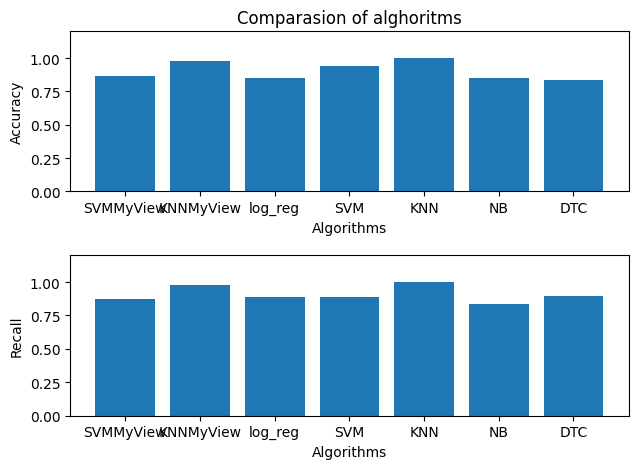

In [182]:
fig, ax = plt.subplots(2)
ax[0].set_title("Comparasion of alghoritms")
ax[0].set_ylim((0, 1.2))
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Algorithms")
ax[0].bar(list(accuracies.keys()), list(accuracies.values()))


ax[1].set_ylim((0, 1.2))
ax[1].set_ylabel("Recall")
ax[1].set_xlabel("Algorithms")
ax[1].bar(list(recalls.keys()), list(recalls.values()))


fig.tight_layout()
plt.show()

In [183]:
cm_svm_my = confusion_matrix(y_test, y_test_prediction_svm_my)
cm_knn_my = confusion_matrix(y_test, y_test_prediction_knn_my)
cm_log = confusion_matrix(y_test, y_test_prediction_log)
cm_svm = confusion_matrix(y_test, y_test_prediction_svm)
cm_knn = confusion_matrix(y_test, y_test_prediction_knn)
cm_nb = confusion_matrix(y_test, y_test_prediction_nb)
cm_dtc = confusion_matrix(y_test, y_test_prediction_dtc)

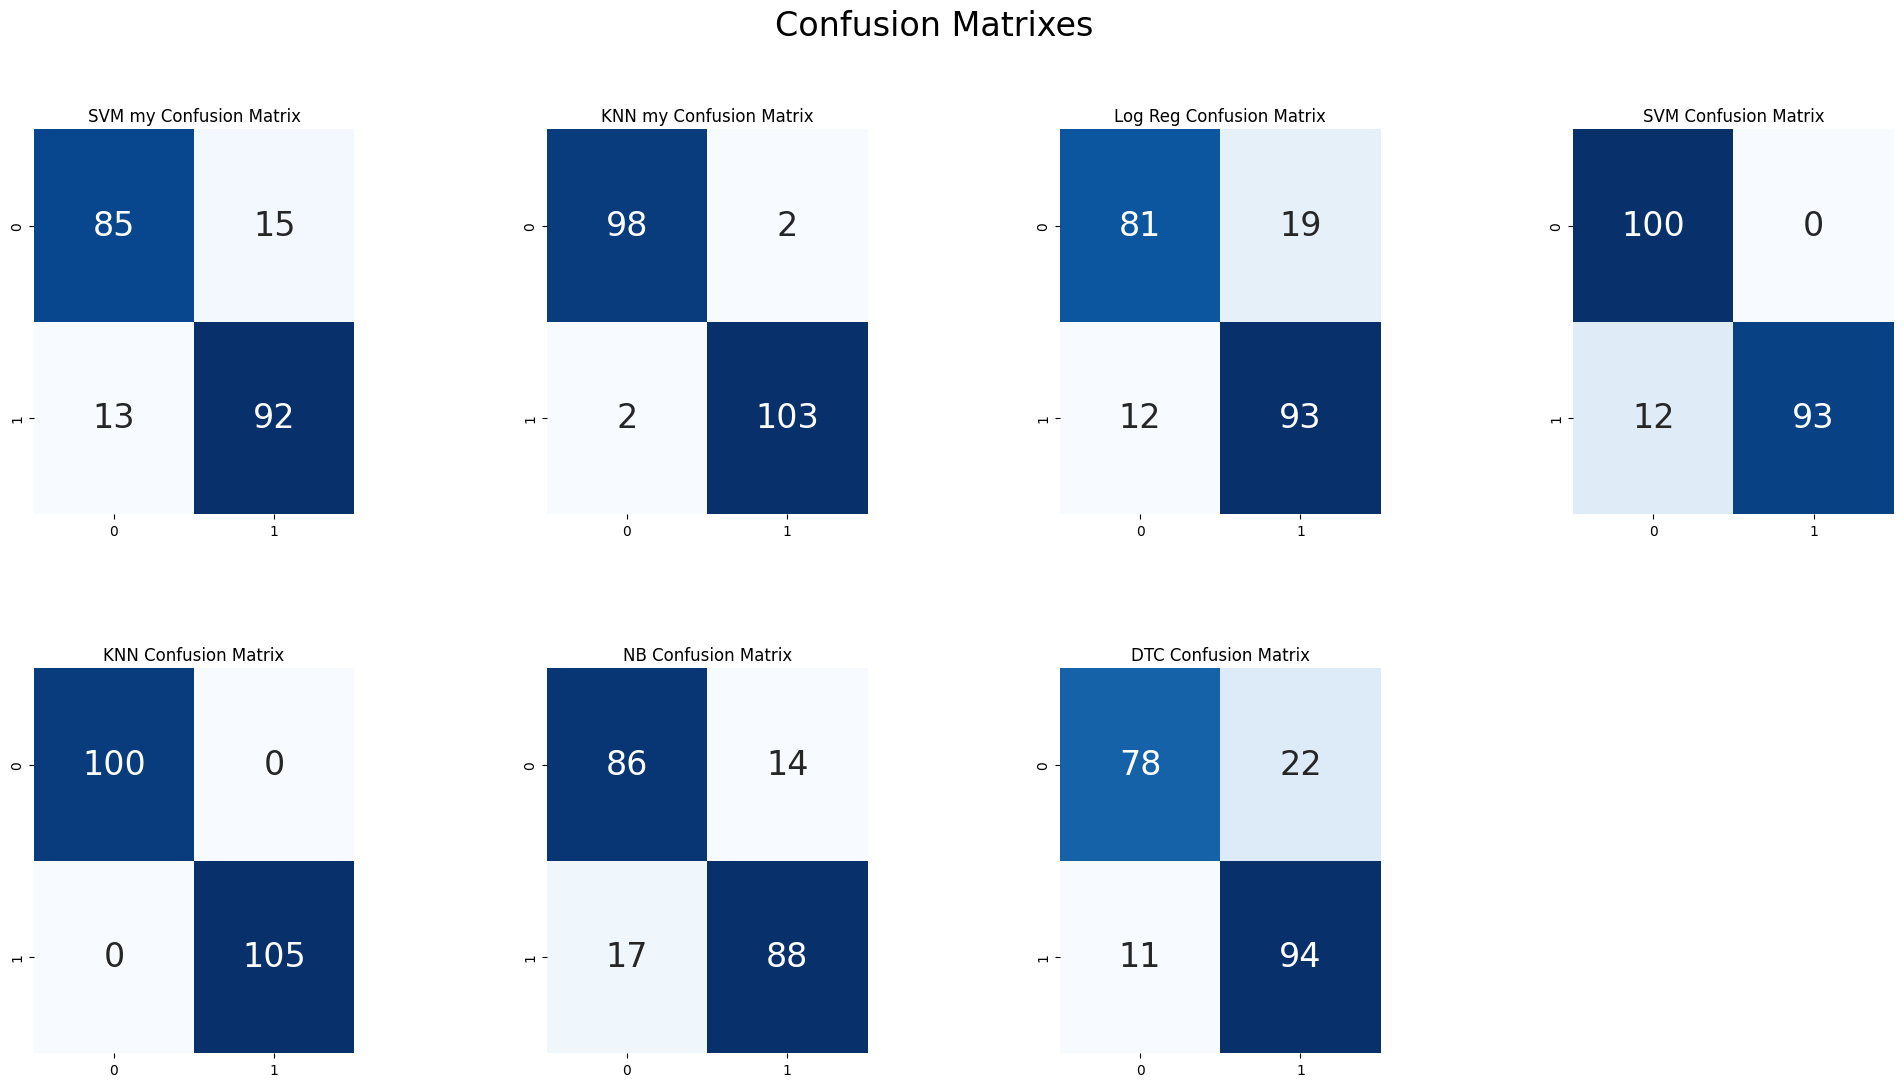

In [184]:
plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrixes", fontsize=24)
plt.subplots_adjust(wspace = 0.6, hspace= 0.4)

plt.subplot(2,4,1)
plt.title("SVM my Confusion Matrix")
sns.heatmap(cm_svm_my, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,2)
plt.title("KNN my Confusion Matrix")
sns.heatmap(cm_knn_my, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,3)
plt.title("Log Reg Confusion Matrix")
sns.heatmap(cm_log, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,4)
plt.title("SVM Confusion Matrix")
sns.heatmap(cm_svm, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,5)
plt.title("KNN Confusion Matrix")
sns.heatmap(cm_knn, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,6)
plt.title("NB Confusion Matrix")
sns.heatmap(cm_nb, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,7)
plt.title("DTC Confusion Matrix")
sns.heatmap(cm_dtc, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.show()

### ПОВТОР С ДРУГИМ дата сетом

In [185]:
wine=load_wine()

df=pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])


df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [187]:
df.isnull().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

In [188]:
df.target.unique()

array([0., 1., 2.])

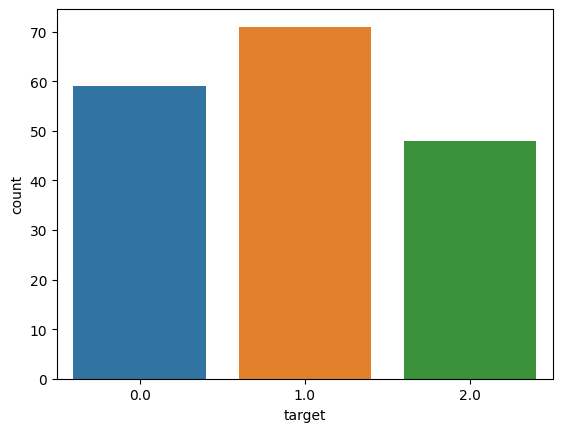

In [219]:
sns.countplot(x="target", data=df)
plt.show()

In [190]:
df['target'].value_counts()

1.0    71
0.0    59
2.0    48
Name: target, dtype: int64

In [191]:
df[['alcohol','magnesium','color_intensity']].corr()

,alcohol,magnesium,color_intensity
alcohol,1.000000,0.270798,0.546364
magnesium,0.270798,1.000000,0.199950
color_intensity,0.546364,0.199950,1.000000


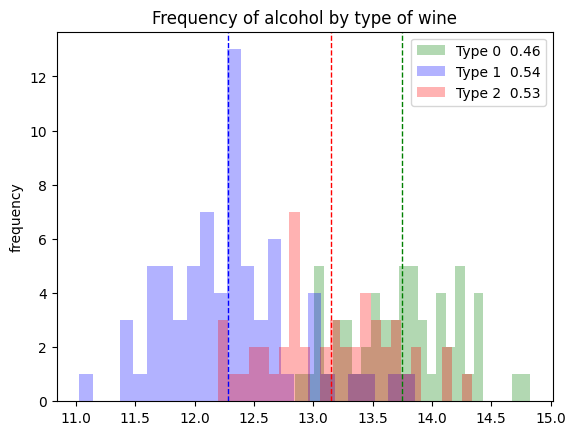

In [192]:
x1 = df.loc[df.target==0, 'alcohol']
x2 = df.loc[df.target==1, 'alcohol']
x3 = df.loc[df.target==2, 'alcohol']

kwargs = dict(alpha=0.3,bins=25)

plt.hist(x1, **kwargs, color='g', label='Type 0'+  str("{:6.2f}".format(x1.std())))
plt.hist(x2, **kwargs, color='b', label='Type 1'+  str("{:6.2f}".format(x2.std())))
plt.hist(x3, **kwargs, color='r', label='Type 2'+  str("{:6.2f}".format(x3.std())))
plt.gca().set(title='Frequency of alcohol by type of wine', ylabel='frequency')
plt.axvline(x1.mean(), color='g', linestyle='dashed', linewidth=1)
plt.axvline(x2.mean(), color='b', linestyle='dashed', linewidth=1)
plt.axvline(x3.mean(), color='r', linestyle='dashed', linewidth=1)
plt.legend();

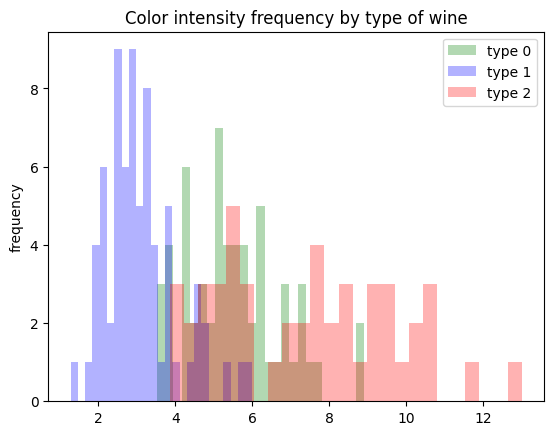

In [193]:
x1 = df.loc[df.target==0, 'color_intensity']
x2 = df.loc[df.target==1, 'color_intensity']
x3 = df.loc[df.target==2, 'color_intensity']

kwargs = dict(alpha=0.3,bins=25)

plt.hist(x1, **kwargs, color='g', label='type 0')
plt.hist(x2, **kwargs, color='b', label='type 1')
plt.hist(x3, **kwargs, color='r', label='type 2')
plt.gca().set(title='Color intensity frequency by type of wine', ylabel='frequency')

plt.legend();

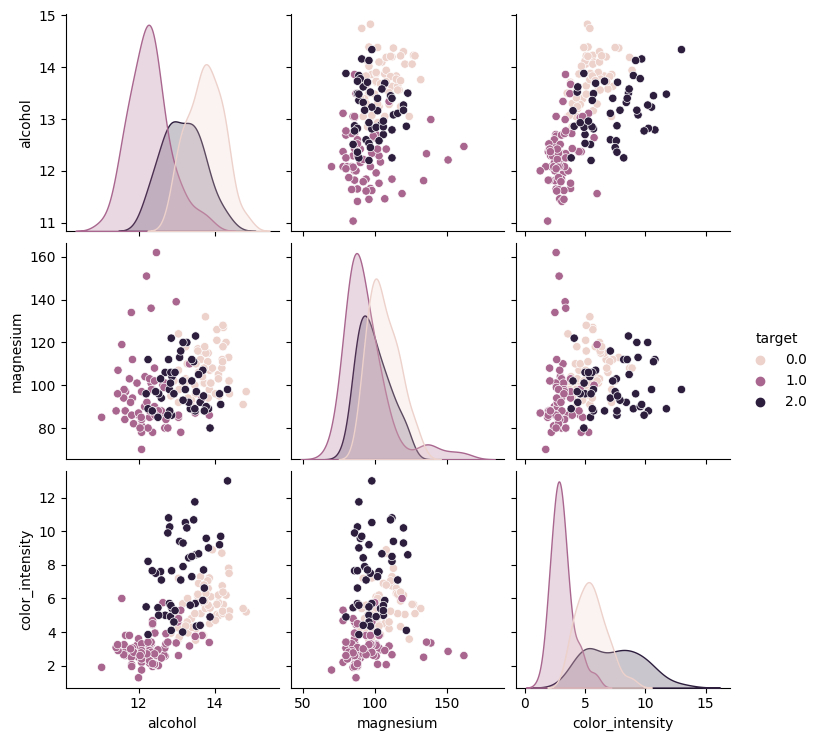

In [194]:
features = df[['alcohol','magnesium','color_intensity','target']]
sns.pairplot(features,hue='target')

#### Случайным образом разбить данные на обучающую и тестовую выборки, используя методы существующих библиотек.

In [195]:
x = df.drop(['target'], axis=1)
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [196]:
# Масштабирование данных
scaler = StandardScaler()

x_train_scaled_raw = scaler.fit_transform(x_train)
x_test_scaled_raw = scaler.transform(x_test)

x_train_scaled = pd.DataFrame(x_train_scaled_raw, columns=x.columns)
x_test_scaled = pd.DataFrame(x_test_scaled_raw, columns=x.columns)
x_train_scaled.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,-0.350782,1.425547,0.114730,1.010413,0.132338,0.814001,0.450459,0.535244,0.541254,-1.038810,1.000624,0.696617,-0.915940
1,-0.578832,-0.502164,-1.395755,0.290428,-1.046767,-0.231370,-0.192253,-0.342039,-0.294547,-0.877824,0.325383,1.317245,-0.248538
2,0.045306,-1.249827,-2.366780,-1.005545,-0.973073,-0.646199,-0.080034,-0.980063,-0.330113,-0.155563,1.000624,-0.220220,-1.142665
3,0.993516,-0.484148,0.186658,-1.581533,0.869279,2.556286,1.664471,-0.342039,0.398990,0.910426,0.190335,0.879984,1.405596
4,-1.479031,0.353595,1.984854,0.146431,0.279726,-0.978063,-0.080034,1.891044,-1.059216,-0.503640,1.180688,-0.192009,-0.456103


In [197]:
rfecv = RFECV(estimator=LogisticRegression())

rfecv.fit(x_train_scaled, y_train)

selected_features = list(x_train_scaled.columns[rfecv.support_])

print(f'Оптимальных признаков: {rfecv.n_features_}\nПризнкаи:{selected_features}')

Оптимальных признаков: 8
Признкаи:['alcohol', 'ash', 'alcalinity_of_ash', 'flavanoids', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


In [198]:
x_train_scaled = x_train_scaled[selected_features]
x_test_scaled = x_test_scaled[selected_features]
x_train_scaled.head()

,alcohol,ash,alcalinity_of_ash,flavanoids,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,-0.350782,0.114730,1.010413,0.450459,-1.038810,1.000624,0.696617,-0.915940
1,-0.578832,-1.395755,0.290428,-0.192253,-0.877824,0.325383,1.317245,-0.248538
2,0.045306,-2.366780,-1.005545,-0.080034,-0.155563,1.000624,-0.220220,-1.142665
3,0.993516,0.186658,-1.581533,1.664471,0.910426,0.190335,0.879984,1.405596
4,-1.479031,1.984854,0.146431,-0.080034,-0.503640,1.180688,-0.192009,-0.456103


In [199]:
learning_rate_grid = [0.1, 0.001]
iter_num_grid = [100, 1000]
lmda_grid = [0.1, 0.001]

cv = StratifiedKFold(5)
searcher = GridSearchCV(SVMMyView(),
                        [{"learning_rate": learning_rate_grid, "iter_num": iter_num_grid, "lambda_": lmda_grid}],
                        cv=cv, verbose=5)
searcher.fit(x_train_scaled, y_train)

optimal_learning_rate = searcher.best_params_["learning_rate"]
optimal_iter_num = searcher.best_params_["iter_num"]
optimal_lambda = searcher.best_params_["lambda_"]
############
print(f"Optimal options {searcher.best_params_}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END iter_num=100, lambda_=0.1, learning_rate=0.1;, score=0.724 total time=   0.0s
[CV 2/5] END iter_num=100, lambda_=0.1, learning_rate=0.1;, score=0.759 total time=   0.0s
[CV 3/5] END iter_num=100, lambda_=0.1, learning_rate=0.1;, score=0.750 total time=   0.0s
[CV 4/5] END iter_num=100, lambda_=0.1, learning_rate=0.1;, score=0.714 total time=   0.0s
[CV 5/5] END iter_num=100, lambda_=0.1, learning_rate=0.1;, score=0.714 total time=   0.0s
[CV 1/5] END iter_num=100, lambda_=0.1, learning_rate=0.001;, score=0.690 total time=   0.0s
[CV 2/5] END iter_num=100, lambda_=0.1, learning_rate=0.001;, score=0.690 total time=   0.0s
[CV 3/5] END iter_num=100, lambda_=0.1, learning_rate=0.001;, score=0.679 total time=   0.0s
[CV 4/5] END iter_num=100, lambda_=0.1, learning_rate=0.001;, score=0.714 total time=   0.0s
[CV 5/5] END iter_num=100, lambda_=0.1, learning_rate=0.001;, score=0.750 total time=   0.0s
[CV 1/5] END iter_nu

In [200]:
n_neighbors = [3, 5, 7]

cv = StratifiedKFold(5)
knn_clf = GridSearchCV(KNNMyView(), 
                       [{"n_neighbors": n_neighbors}],
                       cv=cv, verbose=5)

knn_clf.fit(x_train_scaled, y_train)

optimal_neighbors = knn_clf.best_params_["n_neighbors"]
############
print(f"Optimal options {knn_clf.best_params_}, best: {knn_clf.best_score_}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .....................n_neighbors=3;, score=0.966 total time=   0.0s
[CV 2/5] END .....................n_neighbors=3;, score=1.000 total time=   0.0s
[CV 3/5] END .....................n_neighbors=3;, score=1.000 total time=   0.0s
[CV 4/5] END .....................n_neighbors=3;, score=0.929 total time=   0.0s
[CV 5/5] END .....................n_neighbors=3;, score=0.964 total time=   0.0s
[CV 1/5] END .....................n_neighbors=5;, score=0.966 total time=   0.0s
[CV 2/5] END .....................n_neighbors=5;, score=1.000 total time=   0.0s
[CV 3/5] END .....................n_neighbors=5;, score=1.000 total time=   0.0s
[CV 4/5] END .....................n_neighbors=5;, score=0.929 total time=   0.0s
[CV 5/5] END .....................n_neighbors=5;, score=0.964 total time=   0.0s
[CV 1/5] END .....................n_neighbors=7;, score=0.966 total time=   0.0s
[CV 2/5] END .....................n_neighbors=7;,

#### Тестирование

In [201]:
accuracies = dict()
recalls = dict()

In [203]:
classifier = SVMMyView(learning_rate=optimal_learning_rate, iter_num=optimal_iter_num, lambda_=optimal_lambda)
classifier.fit(x_train_scaled, y_train)



y_test_prediction_svm_my = classifier.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_test_prediction_svm_my)
recall = recall_score(y_test, y_test_prediction_svm_my, average='macro')

accuracies['SVMMyView'] = accuracy
recalls['SVMMyView'] = recall

print(f"Test Accuracy of SVM my View alghoritm: {accuracy}, recall: {recall}")

Test Accuracy of SVM my View alghoritm: 0.6111111111111112, recall: 0.6410256410256411


In [204]:
classifier = KNNMyView(optimal_neighbors)
classifier.fit(x_train_scaled, y_train)



y_test_prediction_knn_my = classifier.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_test_prediction_knn_my)
recall = recall_score(y_test, y_test_prediction_knn_my, average='macro')

accuracies['KNNMyView'] = accuracy
recalls['KNNMyView'] = recall

print(f"Test Accuracy of KNN my View alghoritm: {accuracy}, recall: {recall}")

Test Accuracy of KNN my View alghoritm: 0.9444444444444444, recall: 0.9487179487179488


In [205]:
log_reg = LogisticRegression(C=0.5)
log_reg.fit(x_train_scaled, y_train)

y_test_prediction_log = log_reg.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_test_prediction_log)
recall = recall_score(y_test, y_test_prediction_log, average='macro')

accuracies['log_reg'] = accuracy
recalls['log_reg'] = recall

print(f"Test Accuracy of logistic regression alghoritm: {accuracy}, recall: {recall}")

Test Accuracy of logistic regression alghoritm: 1.0, recall: 1.0


In [206]:
svm = SVC(C=0.5, gamma=1, kernel='rbf', random_state = 42)
svm.fit(x_train_scaled, y_train)

y_test_prediction_svm = svm.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_test_prediction_svm)
recall = recall_score(y_test, y_test_prediction_svm, average='macro')

accuracies['SVM'] = accuracy
recalls['SVM'] = recall

print(f"Test Accuracy of SVM alghoritm: {accuracy}, recall: {recall}")

Test Accuracy of SVM alghoritm: 0.8333333333333334, recall: 0.8384615384615385


In [207]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(x_train_scaled, y_train)

y_test_prediction_knn = knn.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_test_prediction_knn)
recall = recall_score(y_test, y_test_prediction_knn, average='macro')

accuracies['KNN'] = accuracy
recalls['KNN'] = recall

print(f"Test Accuracy of KNN alghoritm: {accuracy}, recall: {recall}")

Test Accuracy of KNN alghoritm: 0.9444444444444444, recall: 0.9487179487179488


In [212]:
nb = GaussianNB(priors=[0.4, 0.33, 0.27 ], var_smoothing=0.5)
nb.fit(x_train_scaled, y_train)

y_test_prediction_nb = nb.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_test_prediction_nb)
recall = recall_score(y_test, y_test_prediction_nb, average='macro')

accuracies['NB'] = accuracy
recalls['NB'] = recall

print(f"Test Accuracy of naive bayes alghoritm: {accuracy}, recall: {recall}")

Test Accuracy of naive bayes alghoritm: 0.9722222222222222, recall: 0.9743589743589745


In [209]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=5, max_features=2)
dtc.fit(x_train_scaled, y_train)

y_test_prediction_dtc = dtc.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_test_prediction_dtc)
recall = recall_score(y_test, y_test_prediction_dtc, average='macro')

accuracies['DTC'] = accuracy
recalls['DTC'] = recall

print(f"Test Accuracy of SVM my View alghoritm: {accuracy}, recall: {recall}")

Test Accuracy of SVM my View alghoritm: 0.9444444444444444, recall: 0.9487179487179488


#### Сравниение

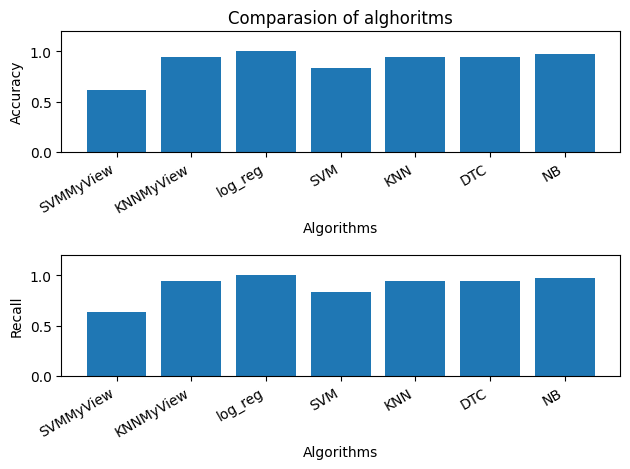

In [218]:
fig, ax = plt.subplots(2)
ax[0].set_title("Comparasion of alghoritms")
ax[0].set_ylim((0, 1.2))
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Algorithms")
ax[0].bar(list(accuracies.keys()), list(accuracies.values()))


ax[1].set_ylim((0, 1.2))
ax[1].set_ylabel("Recall")
ax[1].set_xlabel("Algorithms")
ax[1].bar(list(recalls.keys()), list(recalls.values()))

plt.setp(ax[0].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax[1].get_xticklabels(), rotation=30, horizontalalignment='right')

fig.tight_layout()
plt.show()

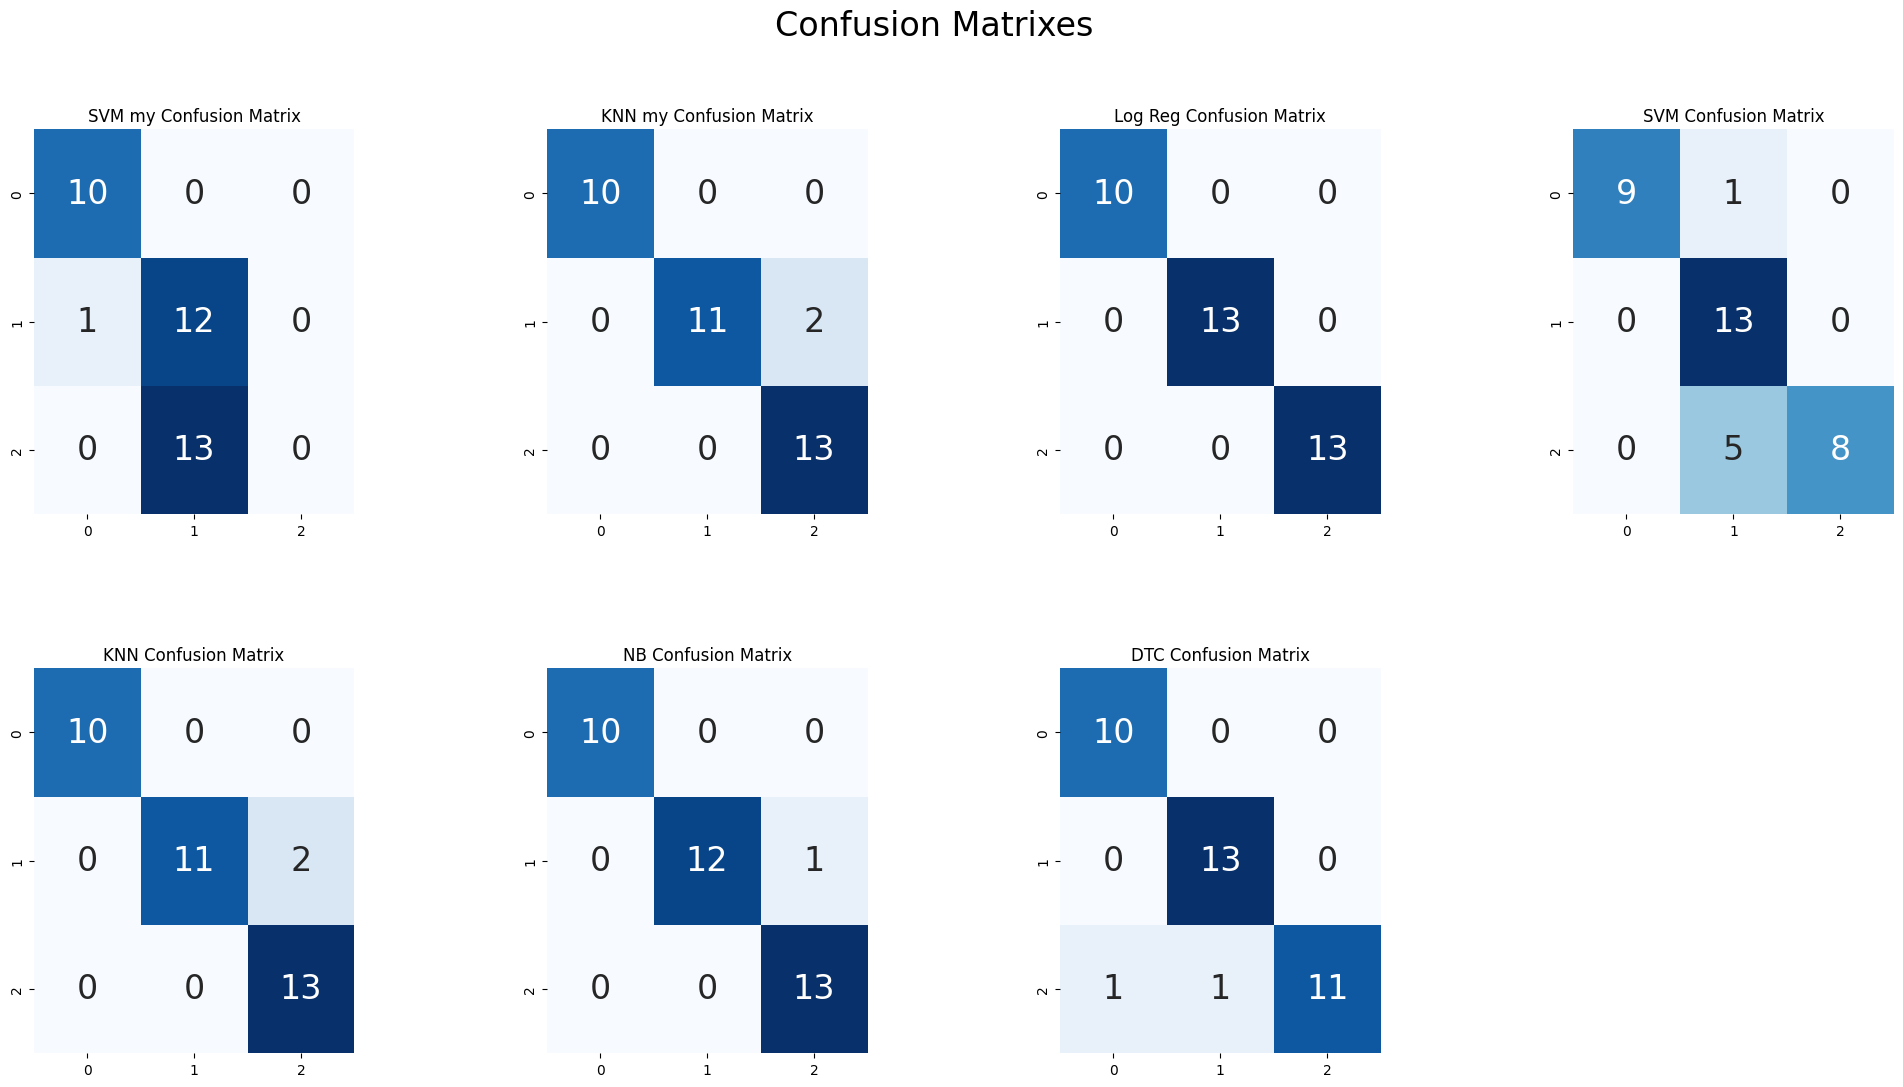

In [214]:
cm_svm_my = confusion_matrix(y_test, y_test_prediction_svm_my)
cm_knn_my = confusion_matrix(y_test, y_test_prediction_knn_my)
cm_log = confusion_matrix(y_test, y_test_prediction_log)
cm_svm = confusion_matrix(y_test, y_test_prediction_svm)
cm_knn = confusion_matrix(y_test, y_test_prediction_knn)
cm_nb = confusion_matrix(y_test, y_test_prediction_nb)
cm_dtc = confusion_matrix(y_test, y_test_prediction_dtc)

plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrixes", fontsize=24)
plt.subplots_adjust(wspace = 0.6, hspace= 0.4)

plt.subplot(2,4,1)
plt.title("SVM my Confusion Matrix")
sns.heatmap(cm_svm_my, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,2)
plt.title("KNN my Confusion Matrix")
sns.heatmap(cm_knn_my, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,3)
plt.title("Log Reg Confusion Matrix")
sns.heatmap(cm_log, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,4)
plt.title("SVM Confusion Matrix")
sns.heatmap(cm_svm, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,5)
plt.title("KNN Confusion Matrix")
sns.heatmap(cm_knn, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,6)
plt.title("NB Confusion Matrix")
sns.heatmap(cm_nb, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,7)
plt.title("DTC Confusion Matrix")
sns.heatmap(cm_dtc, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.show()

### Вывод

Реализованные алгоритмы показывают близкие результаты к аналогичным из библиотеки sklearn. Реализация KNN показала более близкий результат к аналогичному алгоритму из  sklearn. С датасетом wine SVM показал наихудший результат, как в моей реализации, так и в реализации sklearn, возможно это связано с тем, что целевой признак датасета wine имеет 3 возможных значения.